# Exercise 1.5.3 - Learning Rate Schedules
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Implement two [learning rate schedules](https://en.wikipedia.org/wiki/Learning_rate#Learning_rate_schedule): the [exponential decay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay) and [step-wise annealing](https://paperswithcode.com/method/step-decay) strategies;
* Use the off-the-shelf [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) and the custom LR schedule [`tf.keras.callbacks.LearningRateScheduler`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) wrapper to implement the above strategies;
* Evaluate a lightweight deep neural network (simple [ConvNet](https://en.wikipedia.org/wiki/Convolutional_neural_network)) with the LR schedules on the [GTSRB](https://benchmark.ini.rub.de/gtsrb_dataset.html) dataset.

## 1. Introduction

In [1]:
### Importing the required modules

In [2]:
from collections import defaultdict
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from typing import Generator, Iterator, List, Tuple

In [3]:
tf.__version__

'2.8.2'

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
### Setting the environment variables

In [6]:
ENV_COLAB = True                # True if running in Google Colab instance

In [7]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [8]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [9]:
### Unzipping the GTSRB dataset
#!unzip -q /content/GTSRB.zip -d /content/data/

In [10]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Learning Rate Schedules

In machine learning and statistics, the [learning rate](https://en.wikipedia.org/wiki/Learning_rate) is a tunable hyperparameter in an optimisation algorithm that determines the step size at each iteration while moving towards a minimum of a loss function (credit: Wikipedia). Setting learning rates optimally is often a balancing act between over- and overshooting a global minima. When the learning rate is _too low_, a model might fail to converge as its steps in the direction of a function minima are simply too small. On the other hand, a learning rate that is _too high_ might result in extremely large steps that _overshoot_ the function minima and miss the target entirely. An optimal (fixed) learning rate value should be selected such that the likelihood of overshooting is minimised and that is sufficiently large to perform steepest descent towards convergence.

A [learning rate schedule](https://en.wikipedia.org/wiki/Learning_rate#Learning_rate_schedule) helps accomplish this by not only decreasing overshoot but also speeding up the time it could take to reach convergence. LR schedules have two important properties: _decay_ and _momentum_. Decay is a hyperparameter that controls overshooting by decreasing (_annealing_) the learning rate by a fixed factor. Momentum is another hyperparameter that helps us speed up the convergence time. Analogous to a ball rolling down a hill; momentum governs how quickly our learning rate decays. This is extremely useful for making sure that the direction we move in towards steepest descent is indeed towards the global minima and not just towards a local minimum (as a ball with little to no momentum will struggle to 'get over' the shallow [saddle points](https://en.wikipedia.org/wiki/Saddle_point) of the differentiable function.

#### Step-wise Annealing

One of the easiest learning rate schedules to implement is the [step-wise method](https://paperswithcode.com/method/step-decay). With this schedule, the learning rate is decreased by a static factor at evenly-spaced intervals during the training cycle (usually measured in epochs, i.e., full passes over a dataset). The scale factor $\gamma$ serves as a hyperparameter governing how much to decrease the previous learning rate $\eta_{i-1}$ by,

$$
\begin{align}
\eta_{i} &= \eta_{i-1} * \gamma, 
\end{align}
$$

for the updated learning rate value $\eta_{n}$.

Step-wise annealing can also be, well, _step-wise_. As the name implies, the number of current _steps_ $n$ can also be used to scale the initial fixed learning rate value $\eta_{0}$,

$$
\begin{align}
\eta_{i} = \eta_{0} * d^{\left\lfloor\frac{1 + n}{r}\right\rfloor},
\end{align}
$$

given a static decay factor $d$ (e.g., $d=0.5$ will decay the LR by half) and a drop-rate $r$ (e.g., $r=10$ will drop the LR every 10 iterations).

#### Exponential Decay

[Exponential Decay](https://paperswithcode.com/method/exponential-decay) is similar to step-wise annealing in that the LR is gradually decreased over time. However, instead of a linear step-based decay, a scaled, reflected exponential function is used to reduce the initial fixed learning rate $\eta_{0}$ over time,

$$
\begin{align}
\eta_{n} &= \eta_{0} * \mathcal{e}^{-dn}, \\
\end{align}
$$

given a static decay factor $d$ and the current number of iterations $n$. Depending on the choice of the decay factor $d$, the Exponential Decay schedule could (preferably) accelerate the learning rate decay more rapidly than with step-wise annealing.

### 1.2. Adaptive Learning Rate Methods

Given that both the learning rate and its schedules have hyperparameters that need to be manually selected and defined prior to training, a learning rate schedule might not always be optimal. Instead, we can use [adaptive learning rate](https://en.wikipedia.org/wiki/Learning_rate#Adaptive_learning_rate) methods to utilise heuristic approaches to parameter selection that provide reliable results. Adaptive learning rate methods such as [Adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad), [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) build upon the [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) optimiser with adaptive learning rate tuning.

#### AdaGrad

The [AdaGrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad) (Adaptive Gradient) algorithm [1] was pioneered in 2011 by J. Duchi et al., and is a dynamic technique for the normalisation of parameter updates. In brief; weights who receive large gradient update values will have their effective learning rate reduced. Conversely, weights with small or infrequently-updated values will have their effective learning rate increased. Using a parameter referred to as a "cache" variable $c$, AdaGrad performs the following updates,

$$
\begin{align}
c &= c + dx^2, \\
x &= x - \alpha \frac{dx}{\sqrt{x} + \epsilon}.
\end{align}
$$

The cache variable $c$ keeps track of the per-parameter sum of the squared gradients, which in turn is used to normalise the parameter updates. Here an $\epsilon$ term is added to the denominator of the update term for numerical stability (to avoid a divide by zero error), credit: [G. Singh](https://medium.com/@gsinghviews/adaptive-learning-rate-methods-e6e00dcbae5e). 

To utilise AdaGrad in TensorFlow Keras, instantiate the [`tf.keras.optimizers.Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad) optimizer.

#### RMSProp

The [RMSProp](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) (Root Mean Square Propagation) algorithm is another technique that updates the learning rate for each weight dynamically. RMSProp, however, seeks to penalise the weights that cause the cost function to oscillate too much. The expontentially-weighted moving average of the squared gradients are computed such that

$$
\begin{align}
c &= \gamma * c + \left(1 - \gamma\right) \cdot dx^2, \\
x &= x - \alpha \frac{dx}{\sqrt{x} + \epsilon}.
\end{align}
$$

As in AdaGrad, we still utilise a cache variable $c$ but instead the moving average of the squared gradients is computed. This is to handle the monotonically decreasing learning rate behaviour of AdaGrad. Here, $\gamma$ is the _forgetting factor_ hyperparameter. Note that the weight updates are performed element-wise in both a horizontal ($w$) and vertical ($b$) direction. The goal of RMSProp is to slow down the movement in the vertical direction with larger horizontal derivatives while simultaneously increasing the magnitude of the horizontal weight updates. The net effect of RMSProp is a dampening of the oscillatory behaviour of the AdaGrad algorithm while maintaining learning speed-ups in the horizontal direction. 

To utilise RMSProp in TensorFlow Keras, instantiate the [`tf.keras.optimizers.RMSprop`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop) optimizer.

#### Adam

The [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam) (Adaptive Moment Estimation) algorithm by Kingma et al., 2014 ]2\ expands on the RMSProp optimizer by computing the biased first and second moments of the gradients $m$ and $v$,

$$
\begin{align}
m_{t} &= \beta_{1} \cdot m_{t-1} + \left(1 - \beta_{1}\right) \cdot dx, &
v_{t} &= \beta_{2} \cdot v_{t-1} + \left(1 - \beta_{2}\right) \cdot dx^2, \\
\hat{v}_{t} & \leftarrow v_{t} \ \big{/} \left(1 - \beta_{2}^{t}\right) &
\hat{m}_{t} & \leftarrow m_{t} \ \big{/} \left(1 - \beta_{1}^{t}\right). \\
\end{align}
$$
which boil down to essentially computing the mean (moving average of the gradients) and variance (moving average of the _squared_ gradients). Parameters $\beta_{1}$ and $\beta_{2}$ are considered the _forgetting factors_ and selected in the range $[0, 1)$ as exponential decay rates for the moment estimates. The mean and variance calculations are bias-corrected (second line), and used to update the parameters $\theta$ as follows,

$$
\begin{align}
\theta_{t} \leftarrow \theta_{t-1} - \alpha \cdot \hat{m}_{t} \ \big{/} \left(\sqrt{\hat{v}_{t}} + \epsilon\right).
\end{align}
$$

The Adam optimizer borrows not only principles from the RMSProp optimizer but also the step-wise learning rate schedule; the last term in the update step $\hat{m}_{t} \ \big{/} \left(\sqrt{\hat{v}_{t}} + \epsilon\right)$ becomes closer to zero as the parameters approach optimal values, essentially acting as an automatic step-wise annealing.

To utilise Adam in TensorFlow Keras, instantiate the [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

## 2. Programming Task

To do so, you will have to leverage Keras `callbacks`. Callbacks performs various action
at different stages of training. For example, Keras uses a callback to save the models weights at 
the end of each training epoch.

In [11]:
model_params = defaultdict(dict)

In [12]:
### From Udacity's `utils.py`

In [13]:
class LrLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        
    def on_train_begin(self, logs=None):
        history = self.model.history.history
        history['lr'] = []

    def on_epoch_end(self, epoch, logs=None):
        history = self.model.history.history
        optimizer = self.model.optimizer
        decayed_lr = optimizer._decayed_lr('float32').numpy()
        history['lr'].append(decayed_lr)

You can either use pre-implemented schedulers (see Tips) or implement a scheduler yourself 
using your own custom decay function, as shown below:

```
def decay(model, callbacks, lr=0.001):
    """ create custom decay that does not do anything """
    def scheduler(epoch, lr):
        return lr 

    callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

    # compile model
    model.compile()
    
    return model, callbacks 
```

### 2.1. Step-wise Annealing

In [14]:
def step_decay(
        model: tf.keras.Model, callbacks: List[tf.keras.callbacks.Callback]=[], 
        initial_lr: float=0.001
) -> Tuple[tf.keras.Model, List[tf.keras.callbacks.Callback]]:
    """Compiles and returns Model instance with step-wise decay LR schedule.
    
    :param model: the tf.keras.Model instance to compile.
    :param callbacks: the list of tf.keras.callbacks to pass alongside model.
    :param initial_lr: the value to fix the learning rate at before annealing.
    :returns: tuple, the compiled Model instance and its callbacks.
    """
    #  IMPLEMENT THIS FUNCTION
    
    def scheduler(epoch: int, lr: float):
        """Simple custom constant step-wise annealing schedule."""
        return lr / 2 if epoch % 10 == 0 and epoch > 0 else lr
    
    # Instantiate a custom Keras callback to perform LR annealing
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
                            schedule=scheduler, verbose=0
    )
    callbacks.append(lr_schedule)
    # Instantiate the optimiser with the initial learning rate value
    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy']
    )
    # Return the compiled model and the custom LR scheduler and any other callback
    return model, callbacks

In [15]:
model = tf.keras.Model()

In [16]:
model, callbacks = step_decay(model=model, callbacks=[], initial_lr=0.001)

### 2.2. Exponential Decay

In [17]:
### From Udacity's `training.py`

In [18]:
def exponential_decay(
        model: tf.keras.Model, callbacks: List[tf.keras.callbacks.Callback]=[], 
        initial_lr: float=0.001
) -> Tuple[tf.keras.Model, List[tf.keras.callbacks.Callback]]:
    """Compiles and returns Model instance with exponential decay LR schedule.
    
    :param model: the tf.keras.Model instance to compile.
    :param callbacks: the list of tf.keras.callbacks to pass alongside model.
    :param initial_lr: the value to fix the learning rate at before annealing.
    :returns: tuple, the compiled Model instance and its callbacks.
    """
    # IMPLEMENT THIS FUNCTION
    
    # Instantiate the learning rate schedule
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=initial_lr,
                        decay_steps=100,
                        decay_rate=0.95,
                        staircase=False
    )
    # Instantiate the optimiser
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
    # Compile the model
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy']
    )
    # Return the model and any specified callbacks
    return model, callbacks

In [19]:
model = tf.keras.Model()

In [20]:
model, callbacks = exponential_decay(model=model, callbacks=[], initial_lr=0.001)

Feel free to use any decay rates as well as a step size of your choice for the stepwise scheduler.

### 2.3. Training and Validation

The following helper functions are used for the training and validation loops.

In [21]:
### From J. Moran's `2022-09-12-Building-Custom-Convolutional-Neural-Networks.ipynb`

In [22]:
def get_module_logger(mod_name: str) -> logging.Logger:
    """Initialises a console logger instance.
    
    :param mod_name: the model name to assign to the logger.
    :returns: a logger instance.
    """
    
    ### Setting up the console logger and formatter
    logger = logging.getLogger(mod_name)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.DEBUG)
    ### Prevent messages going to root handler
    logger.propagate = False
    return logger

In [23]:
### From Udacity's `utils.py`

In [24]:
def display_metrics(history):
    """ plot loss and accuracy from keras history object """
    f, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(history.history['loss'], linewidth=3)
    ax[0].plot(history.history['val_loss'], linewidth=3)
    ax[0].set_title('Loss', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].legend(['train loss', 'val loss'], loc='upper right')
    ax[1].plot(history.history['accuracy'], linewidth=3)
    ax[1].plot(history.history['val_accuracy'], linewidth=3)
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    ax[1].legend(['train acc', 'val acc'], loc='upper left')
    ax[2].plot(history.history['lr'], linewidth=3)
    ax[2].set_title('Learning rate', fontsize=16)
    ax[2].set_ylabel('Learning Rate', fontsize=16)
    ax[2].set_xlabel('Epoch', fontsize=16)
    ax[2].legend(['learning rate'], loc='upper right')
    # ax[2].ticklabel_format(axis='y', style='sci')
    ax[2].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
    plt.tight_layout()
    plt.show()

In [25]:
logger_step = get_module_logger(step_decay.__name__)

In [26]:
logger_exp = get_module_logger(step_decay.__name__)

### 2.4. Evaluation on the GTSRB dataset

You can run `python training.py` to see the effect of different annealing strategies on your training and model performances. Make sure to feed in the GTSRB dataset as the image directory, and use the Desktop to view the visualization of final training metrics.

#### Considerations for our input data

In [27]:
DATASET_NAME = 'GTSRB'

In [28]:
N_CLASSES = 43                                    # GTSRB has 43 distinct digit classes

In [29]:
### Defining our input image specs

In [30]:
IMG_DIR = os.path.join(DIR_SRC, 'GTSRB/Final_Training/Images')

In [31]:
BATCH_SIZE = 128

In [32]:
IMG_COLOR_MODE = 'rgb'
IMG_SIZE = (32, 32)                               # Each RGB image has 32x32 px resolution
IMG_SHAPE = (32, 32, 3)                           # Each RGB image has 3 channels
N_FEATURES = (32 * 32) * 3                        # Each pixel value is considered an attribute (feature)

In [33]:
model_params[DATASET_NAME].update({'n_classes': N_CLASSES})
model_params[DATASET_NAME].update({'imdir': IMG_DIR})
model_params[DATASET_NAME].update({'batch_size': BATCH_SIZE})
model_params[DATASET_NAME].update({'color_mode': IMG_COLOR_MODE})
model_params[DATASET_NAME].update({'image_size': IMG_SIZE})
model_params[DATASET_NAME].update({'input_shape': IMG_SHAPE})
model_params[DATASET_NAME].update({'n_features': N_FEATURES})

In [34]:
### From J. Moran's `2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb`

In [35]:
def get_datasets(model_params: dict) -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """Return the training and validation datasets.
    
    :param model_params: the dict containing the dataset- and 
        model-specific arguments.
    :returns: (train_dataset, validation_dataset), tuple of tf.data.Dataset 
        instances.
    """
    
    model_params = dict(model_params)
    train_dataset = tf.keras.utils.image_dataset_from_directory(
                        directory=model_params.get('imdir', None),
                        labels='inferred',
                        label_mode='int',
                        color_mode=model_params.get('color_mode', None),
                        batch_size=model_params.get('batch_size', None),
                        image_size=model_params.get('image_size', None),
                        shuffle=True,
                        seed=123,
                        validation_split=0.2,
                        subset='training',
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
                        directory=model_params.get('imdir', None),
                        labels='inferred',
                        label_mode='int',
                        color_mode=model_params.get('color_mode', None),
                        batch_size=model_params.get('batch_size', None),
                        image_size=model_params.get('image_size', None),
                        shuffle=True,
                        seed=123,
                        validation_split=0.2,
                        subset='validation',
    )
    return train_dataset, validation_dataset

In [36]:
### From Udacity's `utils.py`

In [37]:
def get_module_logger(mod_name):
    logger = logging.getLogger(mod_name)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.DEBUG)
    return logger

In [38]:
logger_step = get_module_logger(step_decay.__name__)

In [39]:
logger_exp = get_module_logger(exponential_decay.__name__)

#### Processing the GTSRB data

In [40]:
### From J. Moran's `2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb`

In [41]:
def process(dataset: tf.data.Dataset) -> Generator[tuple, None, None]:
    """Processes the input dataset and returns a generator object.

    :param dataset: the tf.data.Dataset instance of batched image, label data.
    :returns: the generator instance modifying the image attribute values.
    """

    def process_generator()  -> Iterator[Tuple[tf.Tensor, tf.Tensor]]:
        """Scales the input image data.
        
        Unbatches the tf.data.Dataset and scales all image attributes,
        i.e., pixel values, in the range [0, 1].

        :returns: an iterator yielding the modfied image data and
            corresponding label.
        """

        for batch in dataset:
            for image, label in zip(*batch):
                image = tf.cast(image/255., tf.float32)
                yield image, label
    return process_generator

In [42]:
### Fetching the training and validation datasets
train_dataset, validation_dataset = get_datasets(model_params[DATASET_NAME])

Found 4300 files belonging to 43 classes.
Using 3440 files for training.
Found 4300 files belonging to 43 classes.
Using 860 files for validation.


In [43]:
### Number of features (pixel values) in a single image
train_iter = iter(train_dataset)
len(train_iter.get_next()[0][0].numpy().flatten())

3072

In [44]:
### Unbatching the datasets and scaling the images

In [45]:
train_dataset_scaled = tf.data.Dataset.from_generator(
        generator=process(train_dataset), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape', None),
                dtype=tf.dtypes.float32), 
            tf.TensorSpec(
                shape=(),
                dtype=tf.dtypes.int32)
        )
)

In [46]:
validation_dataset_scaled = tf.data.Dataset.from_generator(
        generator=process(validation_dataset), 
        output_signature=(
            tf.TensorSpec(
                shape=model_params[DATASET_NAME].get('input_shape', None),
                dtype=tf.dtypes.float32), 
            tf.TensorSpec(
                shape=(),
                dtype=tf.dtypes.int32)
        )
)

#### Defining our model architecture

In [47]:
MODEL_NAME = 'ConvNet'

In [48]:
def create_network(
        inputs: tf.keras.Input, outputs: tf.keras.layers.Layer, name: str=''
) -> tf.keras.Model:
    """Creates a tf.keras.Sequential Model with the provided inputs and outputs.
    
    :param inputs: the tf.keras.Input layer of specified shape.
    :param outputs: the tf.keras.layers.Layer instance of desired output,
        this should be a Dense layer with units equal to num. classes.
    :param name: str (optional), the name to assign to the model.
    :returns: the tf.keras.Model instance.
    """
    
    net = tf.keras.models.Sequential([
        inputs,
        tf.keras.layers.Conv2D(
            filters=6, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'),
        tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=120, activation='relu'),
        tf.keras.layers.Dense(
            units=84, activation='relu'),
        outputs
    ], name=name)
    return net

In [49]:
### Initialising our Sequential model

In [50]:
inputs = tf.keras.Input(shape=model_params[DATASET_NAME]['input_shape'])
outputs = tf.keras.layers.Dense(units=model_params[DATASET_NAME]['n_classes'])

In [51]:
model = create_network(inputs, outputs)

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 120)               6

#### Testing our learning rate schedules

In [53]:
### Defining our training hyperparameters

In [54]:
EPOCHS = 100

In [55]:
model_params[MODEL_NAME].update({'epochs': EPOCHS})

##### Step-wise Annealing

In [56]:
### Initialise the LR logger and custom callbacks
logger = LrLogger()
callbacks = [logger]

In [57]:
### Compile the model with a custom `step_decay` LR schedule
model, callbacks = step_decay(model, callbacks=callbacks, initial_lr=0.001)

In [58]:
### Batching the train and validation datasets

In [59]:
train_dataset_batched = train_dataset_scaled.batch(
                            model_params[DATASET_NAME]['batch_size']
)
validation_dataset_batched = validation_dataset_scaled.batch(
                            model_params[DATASET_NAME]['batch_size']
)

In [60]:
### Fitting the model on the train data and passing in our callbacks

In [61]:
logger_step.info(f"Training for {model_params[MODEL_NAME]['epochs']} " +
                 f"epochs using {model_params[DATASET_NAME]['imdir']} data")

2022-09-29 19:07:55,066 INFO     Training for 100 epochs using /content/data/GTSRB/Final_Training/Images data
2022-09-29 19:07:55,066 INFO     Training for 100 epochs using /content/data/GTSRB/Final_Training/Images data
2022-09-29 19:07:55,066 INFO     Training for 100 epochs using /content/data/GTSRB/Final_Training/Images data


In [62]:
history_step = model.fit(x=train_dataset_batched, 
                         epochs=model_params[MODEL_NAME]['epochs'],
                         batch_size=model_params[DATASET_NAME]['batch_size'],
                         validation_data=validation_dataset_batched,
                         callbacks=callbacks,
                         shuffle=True
)

Epoch 1/100
27/27 [==============================] - 12s 341ms/step - loss: 8.4819 - accuracy: 0.0221 - val_loss: 7.3587 - val_accuracy: 0.0442 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 7s 225ms/step - loss: 7.4508 - accuracy: 0.0404 - val_loss: 6.6756 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 5s 171ms/step - loss: 6.9826 - accuracy: 0.0238 - val_loss: 6.1918 - val_accuracy: 0.0244 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 5s 169ms/step - loss: 6.5568 - accuracy: 0.0247 - val_loss: 6.0120 - val_accuracy: 0.0407 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 5s 167ms/step - loss: 6.5572 - accuracy: 0.0654 - val_loss: 6.5716 - val_accuracy: 0.0500 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 5s 179ms/step - loss: 6.3901 - accuracy: 0.0360 - val_loss: 5.5210 - val_accuracy: 0.0442 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 5s 169ms/s

In [63]:
### Plot the loss, accuracy and LR decay (if using callbacks)

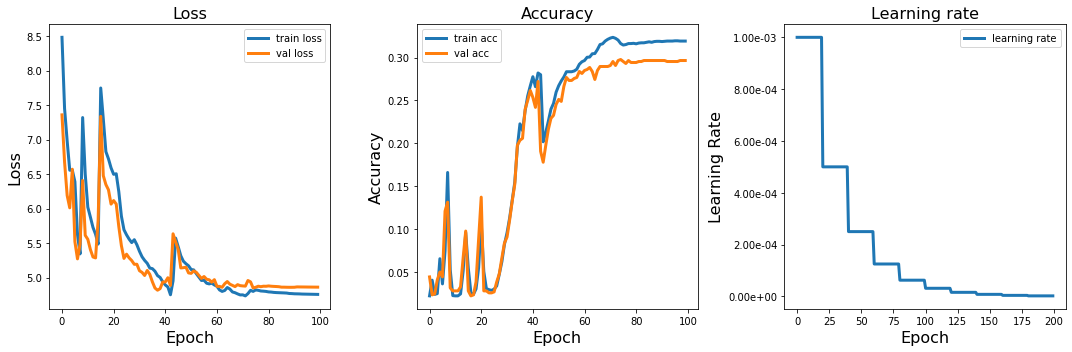

In [64]:
display_metrics(history_step)

##### Exponential Decay

In [65]:
### Initialise the LR logger and custom callbacks
logger = LrLogger()

In [66]:
### Create a list of all desired TensorFlow Keras callbacks
callbacks = [logger]

In [67]:
### Compile the model with a Keras `ExponentialDecay` LR schedule
model = create_network(inputs, outputs)
model, callbacks = exponential_decay(model, callbacks=callbacks, initial_lr=0.1)

In [68]:
### Fitting the model on the train data and passing in our callbacks

In [69]:
logger_exp.info(f"Training for {model_params[MODEL_NAME]['epochs']} " +
                 f"epochs using {model_params[DATASET_NAME]['imdir']} data")

2022-09-29 19:16:17,700 INFO     Training for 100 epochs using /content/data/GTSRB/Final_Training/Images data
INFO:exponential_decay:Training for 100 epochs using /content/data/GTSRB/Final_Training/Images data


In [70]:
history_exp = model.fit(x=train_dataset_batched, 
                        epochs=model_params[MODEL_NAME]['epochs'],
                        batch_size=model_params[DATASET_NAME]['batch_size'],
                        validation_data=validation_dataset_batched,
                        callbacks=callbacks,
                        shuffle=True
)

Epoch 1/100
27/27 [==============================] - 5s 173ms/step - loss: 15.6792 - accuracy: 0.0221 - val_loss: 16.1907 - val_accuracy: 0.0221
Epoch 2/100
27/27 [==============================] - 5s 168ms/step - loss: 15.7690 - accuracy: 0.0235 - val_loss: 16.1907 - val_accuracy: 0.0221
Epoch 3/100
27/27 [==============================] - 5s 167ms/step - loss: 15.7690 - accuracy: 0.0235 - val_loss: 16.1907 - val_accuracy: 0.0221
Epoch 4/100
27/27 [==============================] - 5s 169ms/step - loss: 15.7690 - accuracy: 0.0235 - val_loss: 16.1907 - val_accuracy: 0.0221
Epoch 5/100
27/27 [==============================] - 5s 168ms/step - loss: 15.7690 - accuracy: 0.0235 - val_loss: 16.1907 - val_accuracy: 0.0221
Epoch 6/100
27/27 [==============================] - 5s 170ms/step - loss: 15.7690 - accuracy: 0.0235 - val_loss: 16.1907 - val_accuracy: 0.0221
Epoch 7/100
27/27 [==============================] - 5s 188ms/step - loss: 15.7690 - accuracy: 0.0235 - val_loss: 16.1907 - val_ac

In [71]:
### Plot the loss, accuracy and LR decay (if using callbacks)

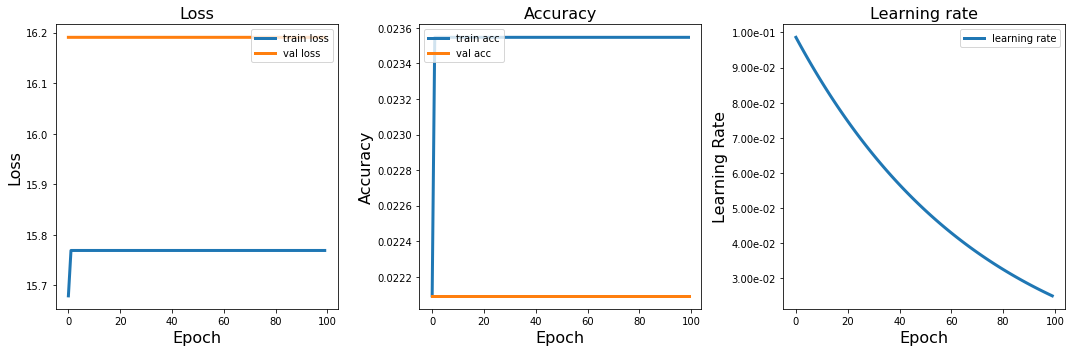

In [72]:
display_metrics(history_exp)

## 3. Closing Remarks

##### Alternatives
* Test out various starting learning rate values.

##### Extensions to task
* Test learning rate strategies on other model architectures;
* Visualise the learning rate schedule over time;
* Implement other [popular](https://paperswithcode.com/methods/category/learning-rate-schedules) learning rate schedules in literature (e.g., [cosine annealing](https://paperswithcode.com/method/cosine-annealing), [linear warmup with linear decay](https://paperswithcode.com/method/linear-warmup-with-linear-decay));
* Implement [adaptive learning rate](https://en.wikipedia.org/wiki/Learning_rate#Adaptive_learning_rate) methods.

## 4. Future Work

- [ ] Visualise learning rate schedule over time;
- [ ] Compare their performance / affect on model accuracy;
- [ ] Implement other popular learning rate schedules.

## Credits

This assignment was prepared by Thomas Hossler et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).


References
* [1] Duchi, J. et al., Adaptive subgradient methods for online learning and stochastic optimization. Journal of Machine Learning Researcher. 12(61):2121–2159. [doi:10.5555/1953048.2021068](https://dl.acm.org/doi/10.5555/1953048.2021068).

* [2] Kingma, D., et al., Adam: A Method for Stochastic Optimization. arXiv. [doi:10.48550/arXiv.1412.6980](https://arxiv.org/abs/1412.6980).


Helpful resources:
* [Learning Rate Schedule in Practice: an example with Keras and TensorFlow 2.0 by B. Chen | Medium](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c)
* [Adaptive Learning Rate Methods by G. Singh](https://medium.com/@gsinghviews/adaptive-learning-rate-methods-e6e00dcbae5e)
* [RMSProp -- Improving Deep Neural Networks: Hyperparameter Tuning, Regularization and Optimization by A. Ng | Coursera](https://www.coursera.org/lecture/deep-neural-network/rmsprop-BhJlm)
* [Everything you need to know about Adam Optimizer  by N. Nikhil | Medium](https://medium.com/@nishantnikhil/adam-optimizer-notes-ddac4fd7218)